In [72]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi, log10
from scipy.stats import norm
import pandas as pd
from util import in_bin_freq
from matplotlib.animation import FuncAnimation

In [73]:
# Simulation Characteristics
timestep = 0.01
simulation_time = 2000
simuls_per_var = 20

# Environment characteristics in SI units
air_density = 1.182014
kinematic_viscosity = 15.52 * 10**(-6)
dynamic_viscosity = 18.37 * 10**(-6)
g = 9.81

# Probability
rock_density_avg = 2990
radius_avg = 0.4
drag_avg = 1.5
theta_avg = 45
relative_std = 0.2

radius_std = radius_avg * relative_std
rock_density_std = rock_density_avg * relative_std
drag_std = drag_avg * relative_std

radius_dist = norm(radius_avg, radius_std)
rock_density_dist = norm(rock_density_avg, rock_density_std)
drag_dist = norm(drag_avg, drag_std)

radius_vals = np.linspace(radius_avg - (3 * radius_std), radius_avg + (3 * radius_std), simuls_per_var)
rock_density_vals = np.linspace(rock_density_avg - (3 * rock_density_std), rock_density_avg + (3 * rock_density_std), simuls_per_var)
drag_vals = np.linspace(drag_avg - (3 * drag_std), drag_avg + (3 * drag_std), simuls_per_var)

ranges = []
max_heights = []
probabilities = []

x_paths = []
y_paths = []

counter = 0

for radius in radius_vals:
    for rock_density in rock_density_vals:
        for drag_coff in drag_vals:

            counter += 1
            if counter % 500 == 0:
                print(f'{(counter / simuls_per_var**3) * 100:.2f}% Done ({counter}/{simuls_per_var**3})')

            probability = radius_dist.pdf(radius) * rock_density_dist.pdf(rock_density) * drag_dist.pdf(drag_coff)
            probability *= radius_std * rock_density_std * drag_std
            probabilities.append(probability)

            # Rock Characteristics in SI units
            volume = (4/3) * pi * radius**3
            mass = volume * rock_density
            surface_area = 4 * pi * radius**2
            cross_sectional_area = pi * radius**2
            characteristic_length = volume / surface_area

            drag = 0.5 * air_density * drag_coff * cross_sectional_area

            x0 = 0
            vx0 = 71
            ax0 = -(drag * vx0**2) / mass

            y0 = 5400 - 2500 # Altitud de Popocateptl (snm) - Altitud (approx.) de Edo. Mex. (snm)
            vy0 = 71
            ay0 = -((drag * vy0**2) / mass) - g

            x_coord = [x0]
            vx = [vx0]
            ax = [ax0]

            y_coord = [y0]
            vy = [vy0]
            ay = [ay0]
            time = [0]

            for i in range(1, round(simulation_time/timestep)):
                t = round((i * timestep) + timestep, 2)
                time.append(t)

                axn = -(drag * vx[i-1] * abs(vx[i-1])) / mass
                vxn = (ax[i-1] * timestep) + vx[i-1]
                xn = (0.5 * ax[i-1] * timestep**2) + (vx[i-1] * timestep) + (x_coord[i - 1])

                ayn = -((drag * vy[i-1] * abs(vy[i-1])) / mass) - g
                vyn = (ay[i-1] * timestep) + vy[i-1]
                yn = (0.5 * ay[i-1] * timestep**2) + (vy[i-1] * timestep) + (y_coord[i - 1])

                if yn < 0 <= y_coord[-1]:
                    ranges.append(xn)
                    break

                ax.append(axn)
                vx.append(vxn)
                x_coord.append(xn)

                ay.append(ayn)
                vy.append(vyn)
                y_coord.append(yn)

            max_heights.append(max(y_coord))

            x_paths.append(x_coord)
            y_paths.append(y_coord)

            # plt.scatter(x_coord, y_coord)
            # plt.show()

            tau = mass / (drag * vx0)
            vx_real = [vx0 / (1 + (t / tau)) for t in time]
            difference = [estimate - real for estimate, real in zip(vx, vx_real)]

            average_velocity = np.average([(x**2 + y**2)**0.5 for x, y in zip(vx, vy)])

            simul_rmse = (sum([diff ** 2 for diff in difference]) / len(difference)) ** 0.5
            simlu_mae = (sum([abs(diff) for diff in difference]) / len(difference))
            simul_mape = sum([abs(diff) / real for diff, real in zip(difference, vx_real)]) / len(difference)

            simul_reynolds = (air_density * average_velocity * characteristic_length) / dynamic_viscosity

6.25% Done (500/8000)
12.50% Done (1000/8000)
18.75% Done (1500/8000)
25.00% Done (2000/8000)
31.25% Done (2500/8000)
37.50% Done (3000/8000)
43.75% Done (3500/8000)
50.00% Done (4000/8000)
56.25% Done (4500/8000)
62.50% Done (5000/8000)
68.75% Done (5500/8000)
75.00% Done (6000/8000)
81.25% Done (6500/8000)
87.50% Done (7000/8000)
93.75% Done (7500/8000)
100.00% Done (8000/8000)


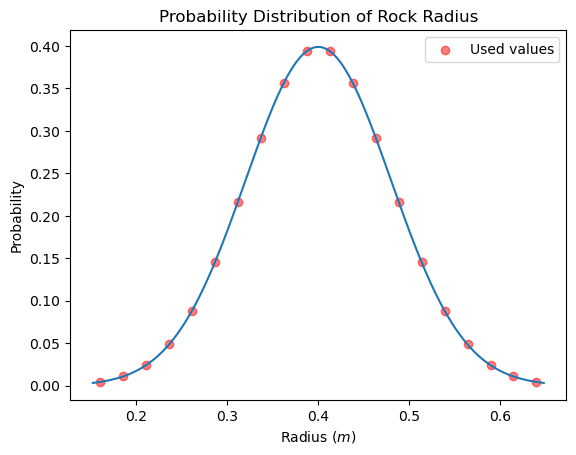

In [74]:
# Radius distribution
space = np.linspace(radius_avg - 3.1*radius_std, radius_avg + 3.1*radius_std, 1000)
plt.plot(space, radius_dist.pdf(space) * radius_std)
plt.scatter(radius_vals, radius_dist.pdf(radius_vals) * radius_std, color='r', alpha=0.5, label='Used values')
plt.title('Probability Distribution of Rock Radius')
plt.xlabel('Radius ($m$)')
plt.ylabel('Probability')
plt.legend()
plt.show()

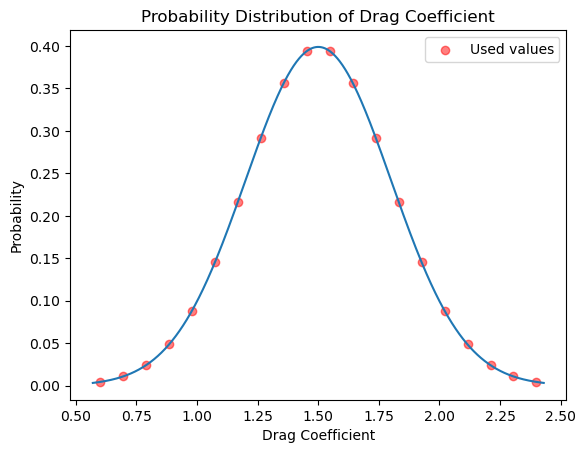

In [75]:
# Drag Coefficient distribution
space = np.linspace(drag_avg - 3.1*drag_std, drag_avg + 3.1*drag_std, 1000)
plt.plot(space, drag_dist.pdf(space) * drag_std)
plt.scatter(drag_vals, drag_dist.pdf(drag_vals) * drag_std, color='r', alpha=0.5, label='Used values')
plt.title('Probability Distribution of Drag Coefficient')
plt.xlabel('Drag Coefficient')
plt.ylabel('Probability')
plt.legend()
plt.show()

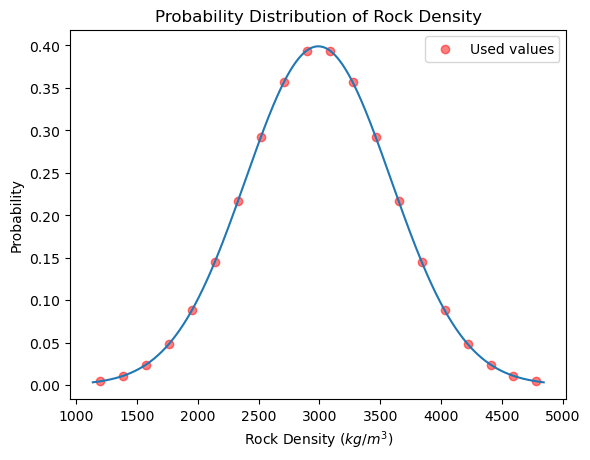

In [76]:
# Rock Density distribution
space = np.linspace(rock_density_avg - 3.1*rock_density_std, rock_density_avg + 3.1*rock_density_std, 1000)
plt.plot(space, rock_density_dist.pdf(space) * rock_density_std)
plt.scatter(rock_density_vals, rock_density_dist.pdf(rock_density_vals) * rock_density_std, color='r', alpha=0.5, label='Used values')
plt.title('Probability Distribution of Rock Density')
plt.xlabel('Rock Density ($kg/m^3$)')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [97]:
num_bins = 20
bin_size = (max(ranges) - min(ranges)) / num_bins
bins = np.linspace(min(ranges) + bin_size, max(ranges), num_bins - 1)
range_freqs = in_bin_freq(bins, ranges, probabilities) / sum(probabilities)

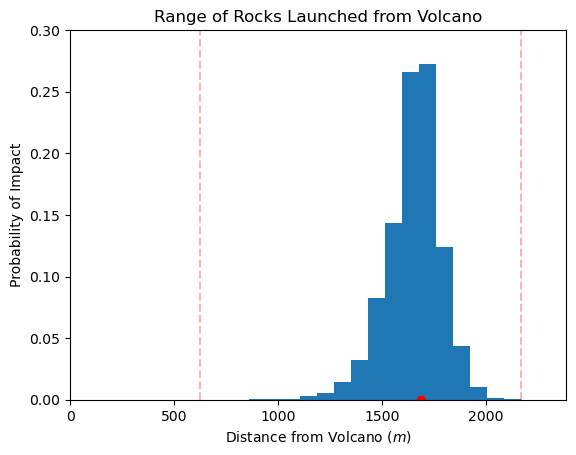

In [113]:
plt.bar(bins, range_freqs, width=-bin_size* 1.1, align='edge')
plt.ylim([0, 0.30])
plt.xlim([0, max(ranges) + 0.1*max(ranges)])
plt.title('Range of Rocks Launched from Volcano')
plt.xlabel('Distance from Volcano ($m$)')
plt.ylabel('Probability of Impact')
plt.axvline(x=min(ranges), alpha=0.3, linestyle='--', color='r')
plt.axvline(x=max(ranges), alpha=0.3, linestyle='--', color='r')
plt.scatter(1688, 0, color='r')
plt.show()

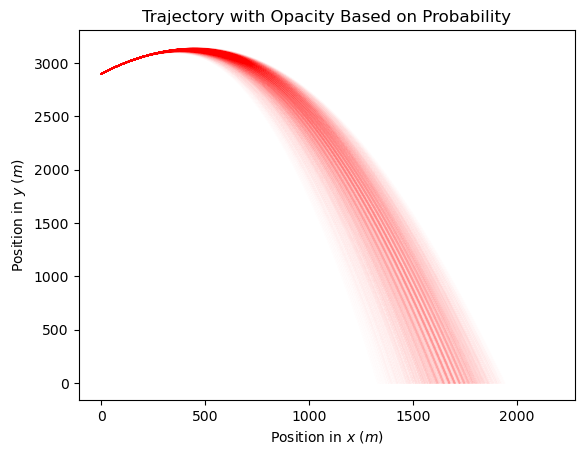

In [115]:
norm_probs = probabilities / sum(probabilities)

for x_path, y_path, prob in zip(x_paths, y_paths, norm_probs):
    plt.plot(x_path, y_path, color='r', alpha=prob * 10)
plt.title('Trajectory with Opacity Based on Probability')
plt.xlabel("Position in $x$ ($m$)")
plt.ylabel("Position in $y$ ($m$)")
plt.show()

In [117]:
max(ranges)

2170.9247114977284